# Actity Recognition From RGB-D Images

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import PIL.Image
import numpy as np
import lightnet as ln
from fastai.vision import *
import xml.etree.cElementTree as ET
import matplotlib
from fastai.metrics import error_rate

## Download

In [3]:
dataset_path = "/home/jupyter/storage/UTKinect_Dataset"
folders = ["depth","rgb"]
label_fname = "actionLabel.txt"

In [4]:
depth_url = "https://cvrc.ece.utexas.edu/KinectDatasets/depth.zip"
rgb_url = "https://cvrc.ece.utexas.edu/KinectDatasets/RGB.zip"
label_url = "https://cvrc.ece.utexas.edu/KinectDatasets/actionLabel.txt"

In [5]:
download_url(depth_url,dataset_path+"/depth.zip")

In [6]:
download_url(rgb_url,dataset_path+"/rgb.zip")

In [7]:
download_url(label_url,"%s/%s"%(dataset_path,label_fname))

## Load Helper Functions

In [8]:
DATA_SIZE = 5865
data_dict = {"depth":[],"rgb":[],"labels":[]}

In [9]:
def string_Arr_to_float(str_arr):
    """
    func: convert all string numbers in list to float
    param:  list of string numbers
    out:  list of float numbers
    """
    for x in range(len(str_arr)):
        str_arr[x] = float(str_arr[x])
    return str_arr

In [10]:
def depth_xml_to_arr(imgFilePath, depthFilePath,beginFrm, endFrm, label):
    """
    func: load depth image data from given range of frames, and append label
    param: depthFilePath - path to file where frames are found
           beginFrm - first frame of activty 
           endFrm - last frame of activty
           label - label of activity
    out: list of touples contatining depth data of each frame between beginFrm and endFrm and label
    """  
    xmlFiles = [f for f in os.listdir(depthFilePath) if f.endswith('.xml')]
    xmlFiles.sort(key=lambda item: (len(item), item))
    
    depthSequence = [[],[]]
    
    beginFrmFile = "depthImg%i.xml" %beginFrm
    endFrmFile = "depthImg%i.xml" %endFrm
    
    beginIdx = xmlFiles.index(beginFrmFile)
    endIdx = xmlFiles.index(endFrmFile)
    useXmlFiles = xmlFiles[beginIdx:endIdx+1]
    
    for xmlFile in useXmlFiles:
        imgFile = xmlFile.replace("depthImg","colorImg").replace(".xml",".jpg")
        img = PIL.Image.open(os.path.join(imgFilePath, imgFile))
        
        tree = ET.parse(os.path.join(depthFilePath, xmlFile))
        filename, _ = os.path.splitext(xmlFile)
        elem = tree.find('%s/data' % filename)
        strData = elem.text
        str_Arr = strData.split()
        floatData = string_Arr_to_float(str_Arr)
        arr = np.array(floatData)
        depthData = np.array(floatData).reshape(240, 320)
        
        img = img.resize((320,240))
        
        data_dict["rgb"].append(np.array(img))
        data_dict["depth"].append(depthData)
        data_dict["labels"].append(label)

In [11]:
# This function should do similar to depth_xml_to_arr, but with rgb images instead of depth
def img_to_arr(imgFilePath,beginFrm, endFrm, label):
    imgs = []
    return imgs

In [12]:
def load_depth_imgs(img_path,depth_path,label_fname):
    """
    func: load depth image data from xml file
    param: depth_path - path to folder with depth data
           label_fname - name of the label txt file
    out: list of touples with depth img and activity label
    """    
    configFile = os.path.join(dataset_path, label_fname)
    with open(configFile, "r") as f:
        lines = f.read().splitlines()

    for i in range(0,220,11):
        currLines = lines[i:i+11]
        depthFileDir = currLines[0]

        print("loading %s" %depthFileDir)
        for line in currLines[1:]:
                splitIdx = line.index(":")
                label = line[:splitIdx]
                nums = line[splitIdx+1:].split()
                beginFrm = int(nums[0])
                endFrm = int(nums[1])
                
                depthFilePath = os.path.join(depth_path,depthFileDir)
                imgFilePath = os.path.join(img_path,depthFileDir)
                
                depth_xml_to_arr(imgFilePath, depthFilePath,beginFrm, endFrm, label)
    
    print("loading complete!")

## Load Data  

In [13]:
depth_path = dataset_path + "/depth"
img_path = dataset_path + "/RGB"
load_depth_imgs(img_path,depth_path,label_fname)

loading s01_e01
loading s01_e02
loading s02_e01
loading s02_e02
loading s03_e01
loading s03_e02
loading s04_e01
loading s04_e02
loading s05_e01
loading s05_e02
loading s06_e01
loading s06_e02
loading s07_e01
loading s07_e02
loading s08_e01
loading s08_e02
loading s09_e01
loading s09_e02
loading s10_e01
loading s10_e02


In [14]:
len(data_dict["rgb"])

5865

In [15]:
depthData = torch.from_numpy(np.array(data_dict['depth'])).permute(0,2,1)
depthData = depthData[:,None,:,:]

In [22]:
imageData = torch.from_numpy(np.array(data_dict['rgb'])).permute(0,1,3,2)
imageData.shape

torch.Size([5865, 240, 3, 320])

TypeError: Invalid shape (3, 320, 240) for image data

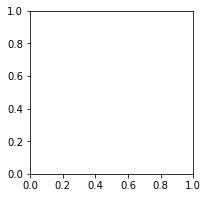

In [27]:
show_image(imageData[0])

## Load Model

In [3]:
model = ln.models.YoloFusion(); model

YoloFusion(
  (layers): ModuleList(
    (0): Sequential(
      (fuse): Conv2d(4, 3, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1_convbatch): Conv2dBatchReLU(3, 32, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1))
    )
    (1): Fusion(
      (Combined): Sequential(
        (2_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (3_convbatch): Conv2dBatchReLU(32, 64, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1))
        (4_max): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (5_convbatch): Conv2dBatchReLU(64, 128, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1))
        (6_convbatch): Conv2dBatchReLU(128, 64, kernel_size=1, stride=1, padding=0, LeakyReLU(negative_slope=0.1))
        (7_convbatch): Conv2dBatchReLU(64, 128, kernel_size=3, stride=1, padding=1, LeakyReLU(negative_slope=0.1))
        (8_max): MaxPool2d(kernel_size=2, stride=2, padding=0,